### From Jacques

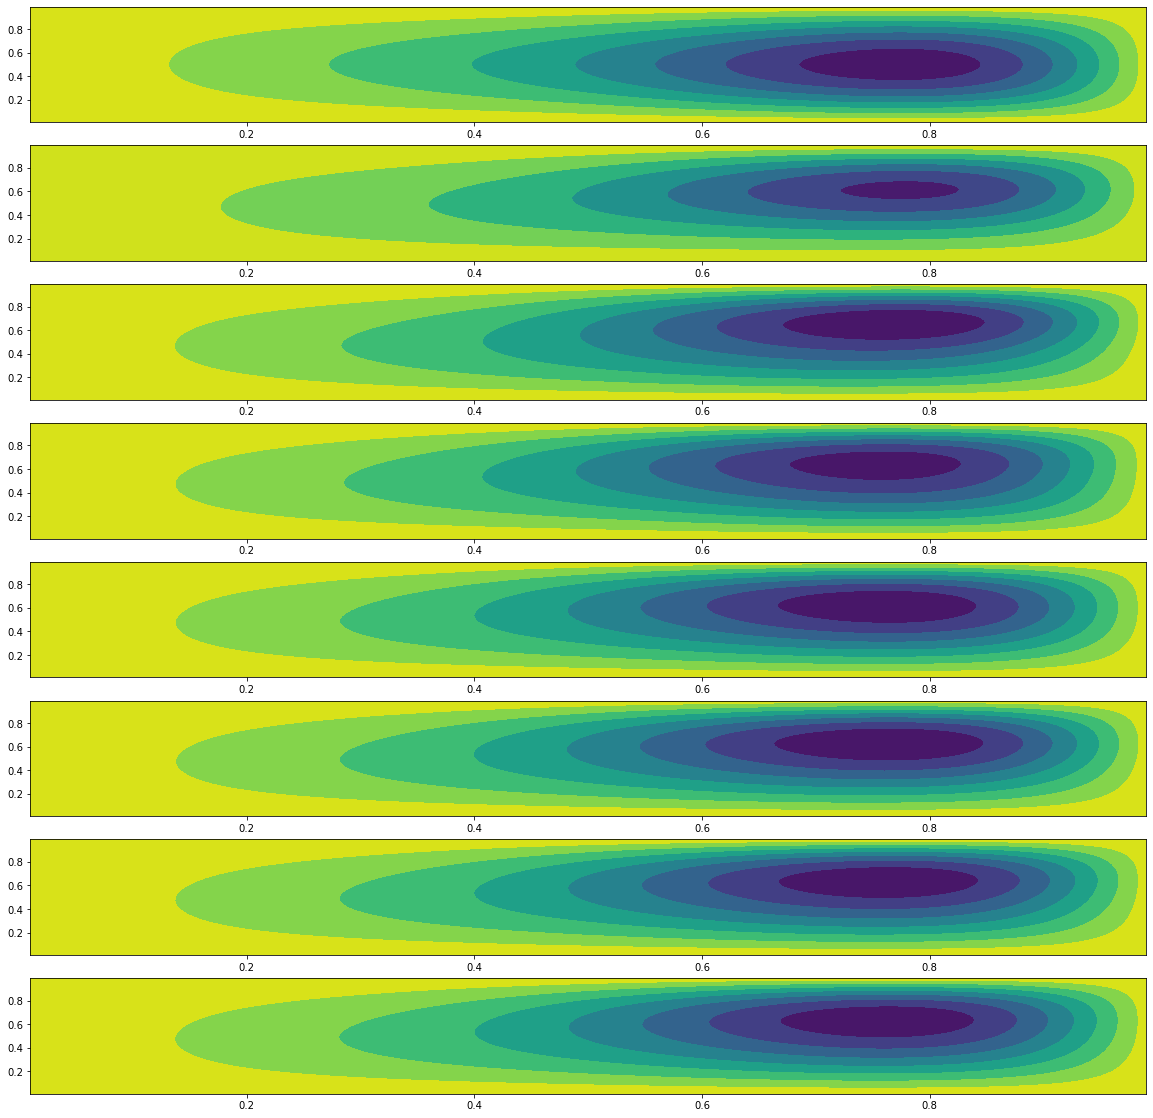

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
#from scipy.sparse.linalg import eigs

def laplacian2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([diag,-2*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(I,mat,format='csr')+sp.kron(mat,I)


def ddx2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([-diag,0*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(I,mat,format='csr')

def ddy2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([-diag,0*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(mat,I)



N = 100
dx = 1/N
x = np.linspace(dx,1-dx,N-1)
y = np.linspace(dx,1-dx,N-1)
x, y = np.meshgrid(x,y)
pi = np.pi

  
lap = laplacian2D(N-1)/dx**2
ddx = ddx2D(N-1)/(2*dx)
ddy = ddy2D(N-1)/(2*dx)
#lap = lap.toarray()

r = 0.1
beta = 1
nu = 0.001

A = r * lap + beta * ddx
B = - nu * lap.dot(lap) - beta * ddx
f = 0.005*np.sin(pi*y)
f_long = np.reshape(f,(N-1)**2)

niter=8
fig, ax = plt.subplots(niter, figsize = (20, 20))

psi_long = np.zeros((N-1)**2)
for i in range(niter):
    q_long = lap.dot(psi_long)
    q_long_x = ddx.dot(q_long)
    q_long_y = ddy.dot(q_long)
    psi_long_x = ddx.dot(psi_long)
    psi_long_y = ddy.dot(psi_long)
    rhs_long = f_long - (psi_long_x*q_long_y - psi_long_y*q_long_x)
    
    
    #psi_long = spsolve(A,rhs_long)
    psi_long = spsolve(B,rhs_long)
    
    psi = np.reshape(psi_long,(N-1,N-1)) 
    ax[i].contourf(x,y,psi)




# psi = np.sin(5*pi*x)*np.sin(3*pi*y)


# psi_long = np.reshape(psi,((N-1)**2,1))

# #q_long = lap.dot(psi_long)
# q_long = ddy.dot(psi_long)

# q = np.reshape(q_long,(N-1,N-1))

# fig, ax = plt.subplots(2)

# ax[0].contourf(x,y,psi)
# ax[1].contourf(x,y,q)

#print(np.max(q)/pi)

#print(lap.toarray())
#vals, vecs = eigs(lap,k=(N-1)**2)
#print(vals)
#print(vecs)

### Compute C_1 and C_2

In [3]:
'''
Compute C_1 and C_2
'''
def C_constant(A, epsilon, root1, root2):
    '''
        Compute C_1, C_2 given A, epsilon and roots for the characteristic equation
    '''
    M = np.array([[1, 1], 
                  [root1, root2]])
    M_A = np.full((2, 1), A/(epsilon * np.pi**2))
    
    C = np.linalg.inv(M) @ M_A
    
    return C[0], C[1]

epsilon = 0.5
A = -np.pi
root1 = (-1 + np.sqrt(1 + 4 * (np.pi**2) * (epsilon**2)))/(2 * epsilon)
root2 = (-1 - np.sqrt(1 + 4 * (np.pi**2) * (epsilon**2)))/(2 * epsilon)

C_1, C_2 = C_constant(A, epsilon, root1, root2)

print(C_1, C_2)

[-0.51140588] [-0.1252139]


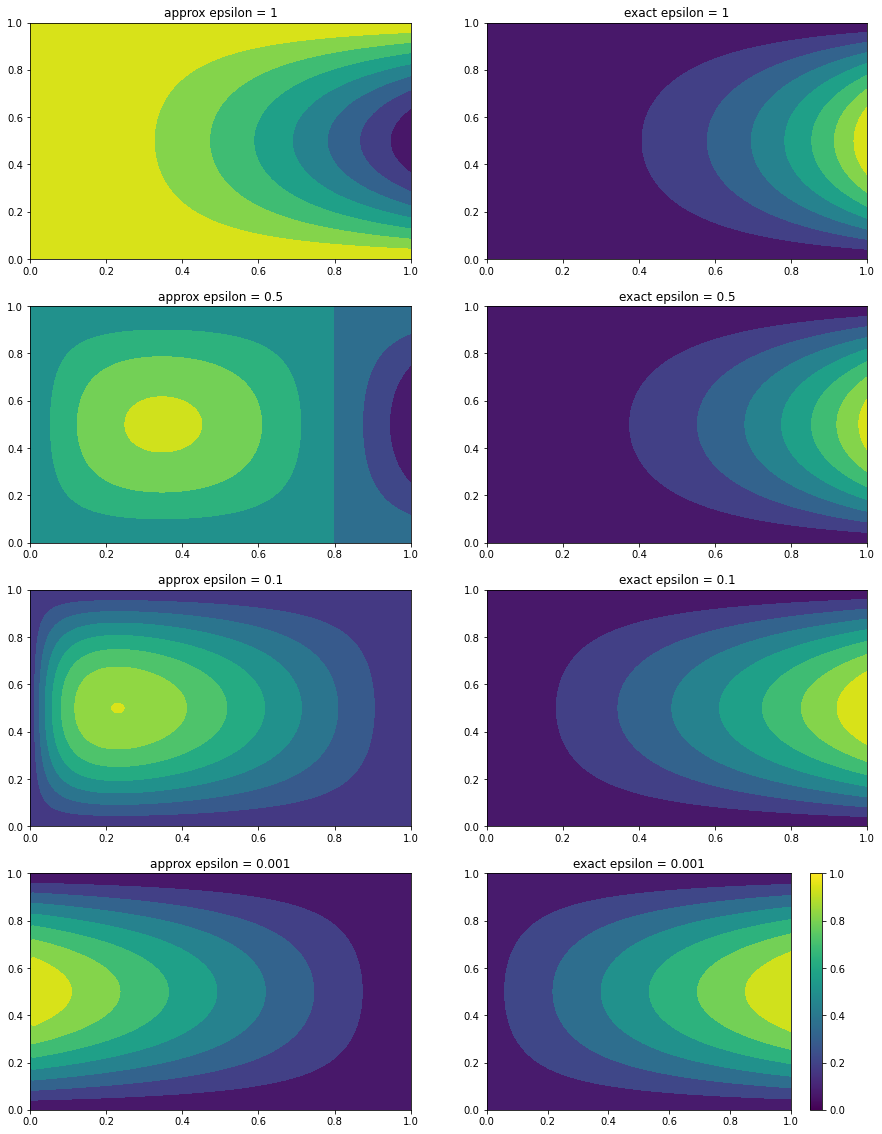

In [4]:
epsilons = [1, 0.5, 0.1, 0.001]

def psi_approx(x, y, epsilon, A):
    return (1 - x - np.exp(-x/epsilon)) * np.pi * np.sin(np.pi * y)

def psi_exact(x, y, epsilon, A, C_1, C_2):
    root1 = (-1 + np.sqrt(1 + 4 * (np.pi**2) * (epsilon**2)))/(2 * epsilon)
    root2 = (-1 - np.sqrt(1 + 4 * (np.pi**2) * (epsilon**2)))/(2 * epsilon)
    
    term1 = C_1 * np.exp(root1 * x)
    term2 = C_2 * np.exp(root2 * x)
    
    return -(term1 + term2 - A/((np.pi**2) * epsilon)) * np.sin(np.pi * y)

# def psi_exact(x, y, epsilon, A, C_1, C_2):
#     return (C_2 * np.exp(np.pi**2 * epsilon * x - x * epsilon **3 * np.pi**4) + \
#            C_1 * np.exp(-x/epsilon - np.pi**2 * epsilon * x + np.pi**4 * epsilon**3 * x) - \
#            A/(np.pi**2 * epsilon)) * np.sin(np.pi * y)

N = 1000
x = 1 - np.linspace(0,1,N)
y = np.linspace(0,1,N)
x, y = np.meshgrid(x,y)

fig, ax = plt.subplots(4, 2, figsize = (15, 20))

for i in range(4):
    epsilon = epsilons[i]
    A = -np.pi
    root1 = (-1 + np.sqrt(1 + 4 * (np.pi**2) * (epsilon**2)))/(2 * epsilon)
    root2 = (-1 - np.sqrt(1 + 4 * (np.pi**2) * (epsilon**2)))/(2 * epsilon)
    
    C_1, C_2 = C_constant(A, epsilon, root1, root2)

    P_approx = psi_approx(x, y, epsilon, A)
    P_exact = psi_exact(x, y, epsilon, A, C_1, C_2)

    ax[i, 0].contourf(x, y, P_approx)
    ax[i, 1].contourf(x, y, P_exact)
    
    ax[i, 0].set(title = f'approx epsilon = {epsilon}', xlim = (0, 1))
    ax[i, 1].set(title = f'exact epsilon = {epsilon}', xlim = (0, 1))


fig.colorbar(plt.cm.ScalarMappable())
plt.show()

In [9]:
from sympy import symbols, integrate, sin, pi

def C_n(g, epsilon, n):
    y = symbols('y')
    A_n = integrate(g(y) * sin(n * np.pi * y), (y, -1, 1))

    root1 = (-1 + np.sqrt(1 + 4 * (n**2) * (np.pi**2) * (epsilon**2)))/(2 * epsilon)
    root2 = (-1 - np.sqrt(1 + 4 * (n**2) * (np.pi**2) * (epsilon**2)))/(2 * epsilon)

    M = np.array([[1, 1], 
                  [root1, root2]])
    M_A = np.full((2, 1), A_n/(epsilon * np.pi**2 * n**2))
    
    C = np.linalg.inv(M) @ M_A
    
    return C[0], C[1]


def g(y):
    return -np.pi * sin(np.pi * y)


C_n(g, 0.5, 1)

(array([-0.511405875701570], dtype=object),
 array([-0.125213896666012], dtype=object))

In [2]:
epsilon = 0.01 
A = 1
#C_1 = 4
C_2 = 5

def psi_approx(x, y):
    return (1 - x - np.exp(-x/epsilon)) * A * np.sin(np.pi * y)

def psi_exact(x, y, C_1):
    return np.sin(np.pi * y) * (C_1 * np.exp((-1 + np.sqrt(1 + 4 * epsilon**2 * np.pi**2))*x) + C_2 * np.exp((-1 - np.sqrt(1 + 4 * epsilon**2 * np.pi**2))*x) - A/(np.pi**2*epsilon))
    
N = 100
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
x, y = np.meshgrid(x,y)

Psi_approx = psi_approx(x, y)
Psi_exact = psi_exact(x, y)

print(Psi_exact.shape)

fig, ax = plt.subplots(2, figsize = (10, 20))
ax[0].contourf(x, y, Psi_approx)
ax[1].contourf(x, y, Psi_exact)

plt.show()

TypeError: psi_exact() missing 1 required positional argument: 'C_1'

In [ ]:
#attempting to vary c 

import matplotlib.animation as animation

epsilon = 0.01 
A = 1
#C_1 = 4
C_2 = 5

def psi_exact(x, y, C_1):
    return np.sin(np.pi * y) * (C_1 * np.exp((-1 + np.sqrt(1 + 4 * epsilon**2 * np.pi**2))*x) + C_2 * np.exp((-1 - np.sqrt(1 + 4 * epsilon**2 * np.pi**2))*x) - A/(np.pi**2*epsilon))
    
N = 100
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
x, y = np.meshgrid(x,y)

# Set the figure size
#plt.rcParams["figure.figsize"] = [7.00, 3.50]
#plt.rcParams["figure.autolayout"] = True

# attempt to plot lol
#data = (x, y, psi_exact(x, y, C_1) )

fig = plt.figure()
ax = plt.axes()


# Method to change the contour data points
def animate(i):
    for i in range(100):
        cont = plt.contourf(x,y,i)
    return cont

# Call animate method
ani = animation.FuncAnimation(fig, animate, 5, interval=50, blit=False)

# Display the plot
plt.show()

#error fix


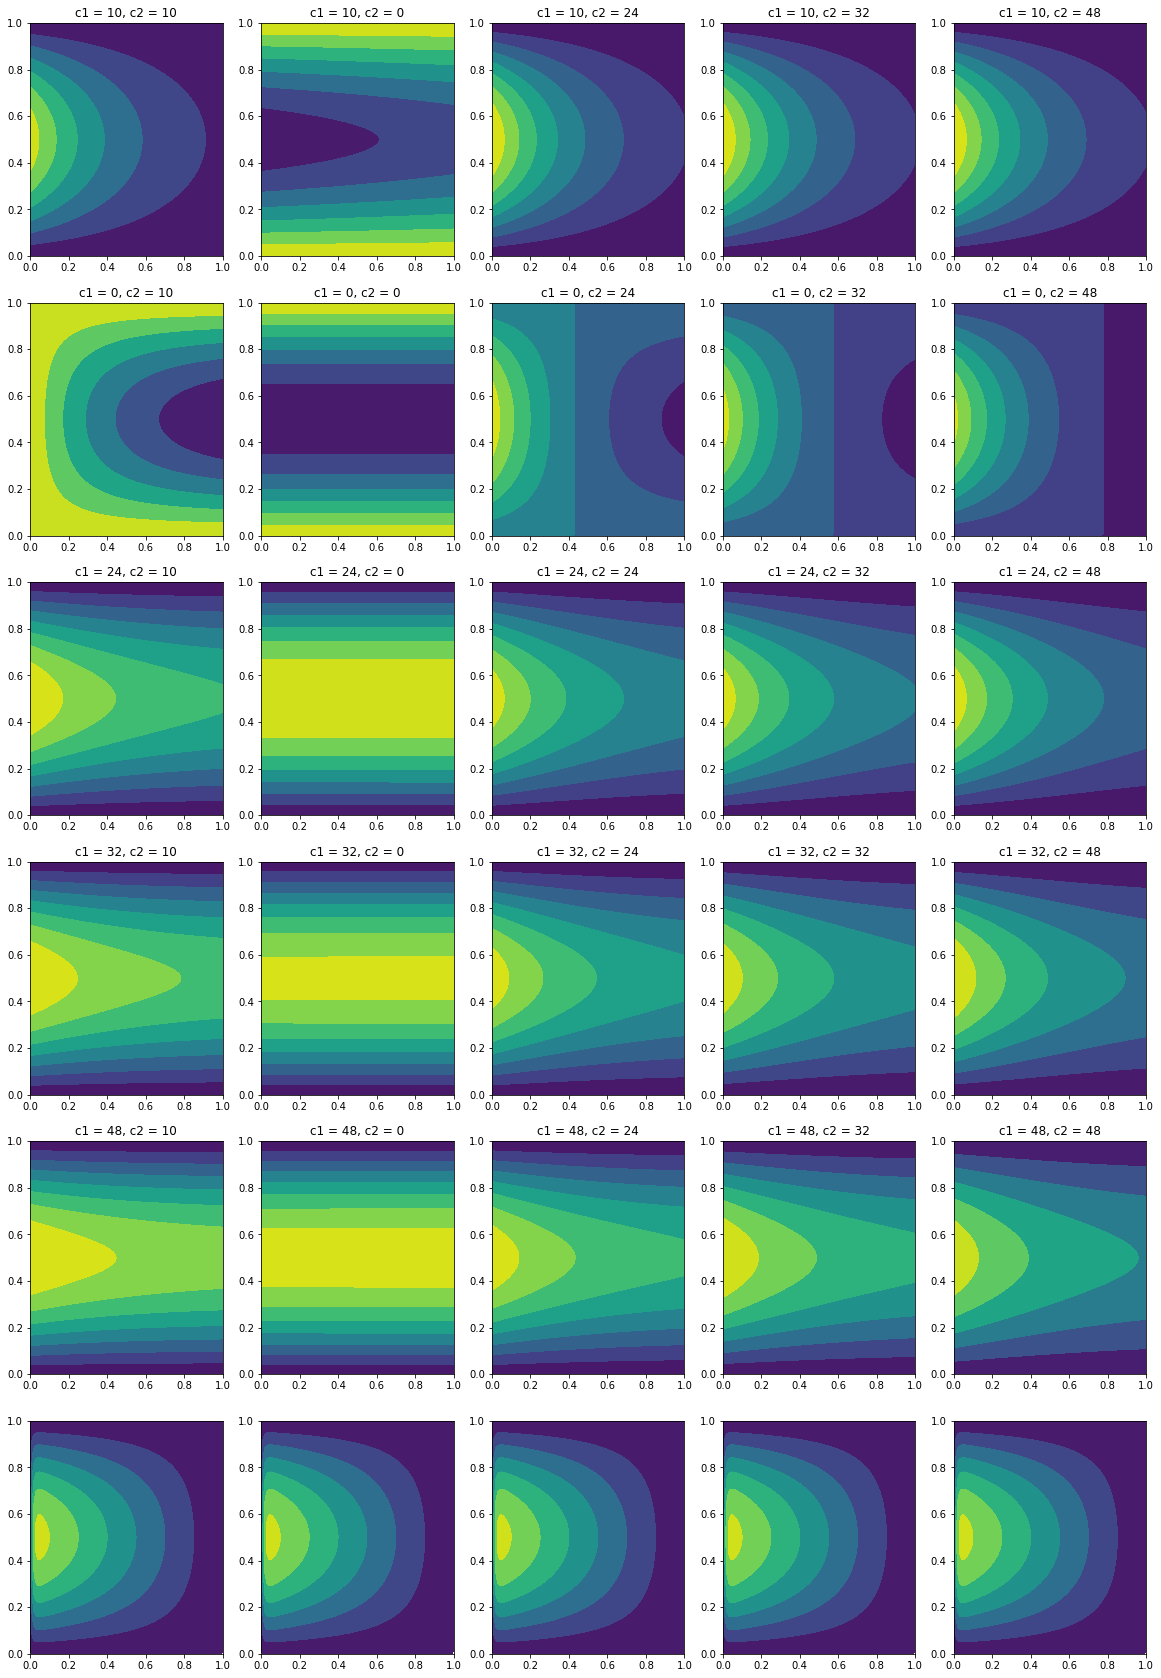

In [3]:
#fresh attempt at c variation using multiple plots rather than animation

epsilon = 0.01 
A = 1

C = [10, 0, 24, 32, 48]

def psi_approx(x, y):
    return (1 - x - np.exp(-x/epsilon)) * A * np.sin(np.pi * y)

def psi_exact(x, y, C_1, C_2):
    return np.sin(np.pi * y) * (C_1 * np.exp((-1 + np.sqrt(1 + 4 * epsilon**2 * np.pi**2))*x) + C_2 * np.exp((-1 - np.sqrt(1 + 4 * epsilon**2 * np.pi**2))*x) - A/(np.pi**2*epsilon))
    
N = 100
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
x, y = np.meshgrid(x,y)

fig, ax = plt.subplots(6,5, figsize = (20,30))

for i in range(6):
    for j in range(5):
        if i == 5:
            ax[i,j].contourf(x,y,psi_approx(x,y))
        else:
            ax[i,j].contourf(x,y,psi_exact(x, y, C[i], C[j]))
            ax[i,j].set_title(f'c1 = {C[i]}, c2 = {C[j]}')



plt.show()

In [4]:
ctest = np.linspace(0, 130)
N = 100
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)

approx = psi_approx(x,y)

for i in ctest:
    for j in ctest:
        exact = psi_exact(x,y,i,j)
        if np.allclose(exact, approx, 0.5, 0.4) == True:
            print(f' optimal c values are {i} and {j}')

#print(round(psi_exact(0.1, 0.2, 5, 3), 2))
#print(psi_approx(0.1, 0.2))
#this isn't right at all 
    
    

 optimal c values are 10.612244897959183 and 0.0


In [9]:
import numpy as np
import sympy as sym
sym.init_printing()
from IPython.display import display_latex

'''
Solve the general stommel equation
'''

#set our parameters?
x = sym.symbols('x')
y = sym.symbols('y')
psi = sym.Function('psi')
laplace = sym.symbols('laplace')
beta = sym.symbols('beta')
r = sym.symbols('r')

#test using solution we already know 
def g(x):
    return sym.pi * sym.sin(x)

stommel = sym.Eq(r*laplace**2*psi(x) + beta*psi(x).diff(x), g(x))

#so our basic equation LOOKS okay
display_latex(stommel)

#idea of solving ~ basically, okay we need this in several variables? right?

eq1sol = sym.dsolve(stommel, psi(x))

display_latex(eq1sol)



In [ ]:
#fourierising 

def

#testetstestets